In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('consumer_complaints.csv')
df.head()

,consumer_complaint,Product
0,XXXX has claimed I owe them {$27.00} for XXXX ...,Debt collection
1,Due to inconsistencies in the amount owed that...,Consumer Loan
2,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
3,I have an open and current mortgage with Chase...,Mortgage
4,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage


(array([17552.,  3678., 14919.,  7929., 12526.,  2128.,  5711.,   726.,
          666.,   971.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

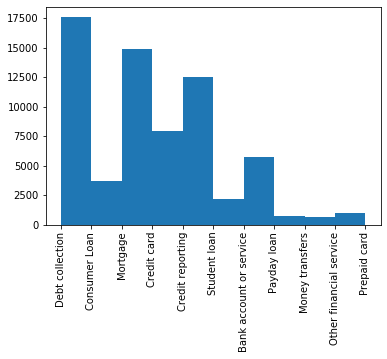

In [3]:
plt.xticks(rotation='vertical')
plt.hist(df.Product)

In [4]:
def print_plot(index):
    example = df[df.index == index][['consumer_complaint', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [5]:
print('example 1:')
print_plot(10)
print('\n\n')
print('example 2:')
print_plot(1000)

example 1:
I am very disappointed that the CFPB did not help to resolve this fraudulant loan. # XXXX between XXXX XXXX and XXXX, FF ( AKA ) One West. Case # XXXX with CFPB. 

Product: Mortgage



example 2:
XXXX XXXX Services is listed on my credit reports as someone I owe money to. That is not true. I have never done business with this agency, and I do not owe them any money. They claim they are representing XXXX XXXX. I have not lived at XXXX XXXX for almost a year. When I was there, I always paid my rent on time. I fulfilled all the obligations of my lease, and I gave notice when I decided to move out. I do not owe them any money, and they never refunded my security deposit. 

Product: Credit reporting


In [6]:
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    # lowercase text
    text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = BAD_SYMBOLS_RE.sub('', text) 
    
    text = text.replace('x', '')
    
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwords from text
    return text
df['consumer_complaint'] = df['consumer_complaint'].apply(clean_text)
df['consumer_complaint'] = df['consumer_complaint'].str.replace('\d+', '')
df.head()

,consumer_complaint,Product
0,claimed owe years despite proof payment sent ...,Debt collection
1,due inconsistencies amount owed told bank amou...,Consumer Loan
2,wages earned job decreased almost half knew tr...,Mortgage
3,open current mortgage chase bank # chase repor...,Mortgage
4,submitted time submitted complaint dealt rushm...,Mortgage


In [7]:
print('example 1:')
print_plot(10)

print()

print('example 2:')
print_plot(1000)

example 1:
disappointed cfpb help resolve fraudulant loan # ff aka one west case # cfpb
Product: Mortgage

example 2:
services listed credit reports someone owe money true never done business agency owe money claim representing lived almost year always paid rent time fulfilled obligations lease gave notice decided move owe money never refunded security deposit
Product: Credit reporting


In [8]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['consumer_complaint'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Found 56802 unique tokens.


In [9]:
from keras.preprocessing.sequence import pad_sequences

X = tokenizer.texts_to_sequences(df['consumer_complaint'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66806, 250)


In [10]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66806, 11)


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.40, random_state = 42)
print("shape of train set", X_train.shape, Y_train.shape)
print("shape of test set",X_test.shape, Y_test.shape)

shape of train set (40083, 250) (40083, 11)
shape of test set (26723, 250) (26723, 11)


In [12]:
from keras.models import Sequential

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Embedding

from keras.preprocessing.text import Tokenizer

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

In [13]:
model = Sequential()


model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length = X.shape[1]))

model.add(SpatialDropout1D(0.5))

model.add(LSTM(20, dropout = 0.5, recurrent_dropout = 0.5))

model.add(Dense(11, activation = 'softmax'))


model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [14]:
history = model.fit(
    X_train, 
    Y_train, 
    epochs = 4, 
    validation_split = 0.1,
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]
)

C:\Users\acchu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36074 samples, validate on 4009 samples
Epoch 1/4
36074/36074 [==============================] - 248s 7ms/step - loss: 1.5731 - accuracy: 0.4642 - val_loss: 1.0380 - val_accuracy: 0.6877
Epoch 2/4
36074/36074 [==============================] - 244s 7ms/step - loss: 1.0771 - accuracy: 0.6636 - val_loss: 0.8738 - val_accuracy: 0.7284
Epoch 3/4
36074/36074 [==============================] - 258s 7ms/step - loss: 0.8900 - accuracy: 0.7258 - val_loss: 0.7398 - val_accuracy: 0.7787
Epoch 4/4
36074/36074 [==============================] - 262s 7ms/step - loss: 0.7669 - accuracy: 0.7661 - val_loss: 0.6522 - val_accuracy: 0.8057


In [15]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

26723/26723 [==============================] - 30s 1ms/step
Test set
  Loss: 0.669
  Accuracy: 0.800


In [16]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

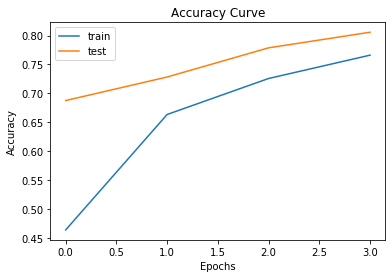

In [17]:
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(range(len(acc)),acc, label='train')
plt.plot(range(len(val_acc)),val_acc, label='test')
plt.legend()
plt.show()

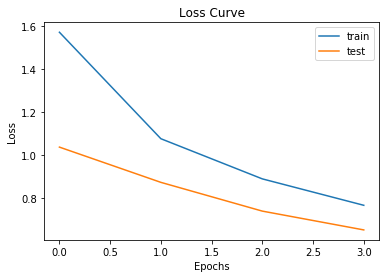

In [18]:
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(len(loss)),loss, label='train')
plt.plot(range(len(val_loss)),val_loss, label='test')
plt.legend()
plt.show()

In [31]:
new_complaint = [
    'This letter is to dispute an incorrectly charged amount on my visa credit card.'
]

seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)

pred = model.predict(padded)

labels = [
    'Credit reporting, credit repair services, or other personal consumer reports', 
    'Debt collection', 
    'Mortgage', 
    'Credit card or prepaid card', 
    'Student loan', 
    'Bank account or service', 
    'Checking or savings account', 
    'Consumer Loan', 
    'Payday loan, title loan, or personal loan', 
    'Vehicle loan or lease', 
    'Money transfer, virtual currency, or money service', 
    'Money transfers', 
    'Prepaid card'
]

print("probability of the complaint belonging to each of the labels")

for i in range(len(pred[0])):
    print(labels[i],"\n",pred[0][i])
    print()

probability of the complaint belonging to each of the labels
Credit reporting, credit repair services, or other personal consumer reports 
 0.012561994

Debt collection 
 0.01281668

Mortgage 
 0.33741555

Credit card or prepaid card 
 0.6079614

Student loan 
 0.015570393

Bank account or service 
 0.00066224363

Checking or savings account 
 0.0073654065

Consumer Loan 
 0.00014815274

Payday loan, title loan, or personal loan 
 0.000656344

Vehicle loan or lease 
 0.003907243

Money transfer, virtual currency, or money service 
 0.0009345992



In [20]:
print("Predicted Label:",labels[np.argmax(pred)])

Predicted Label: Mortgage


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
ypred = model.predict(X_test)

In [23]:
ypred = np.argmax(ypred, axis=1)
Y_test = np.argmax(Y_test, axis=1)

In [24]:
print("Confusion matrix:\n")
print(confusion_matrix(Y_test, ypred))

Confusion matrix:

[[1807   22  244   50  109    0   92    0    0    1    7]
 [  69  490   99  123  381    0  107    0    0    0  170]
 [ 198   41 2538  173  265    0   49    0    0    0    4]
 [  19   47  112 4175  486    0  113    0    0    0   11]
 [  49   77  119  404 6160    0  125    0    0    1   44]
 [ 203    6   14    4   31    0    8    0    0    1    2]
 [  30   43   29   81   73    0 5666    0    0    0   35]
 [  18    2    4    2   14    0    3    0    0    0    2]
 [  30   62    2    8  132    0    5    0    0    0   56]
 [ 204    6  113    1    9    0    0    0    0    5    1]
 [  15  155    6   19   90    0   27    0    0    0  525]]


In [25]:
print("Clasification report:\n")
print(classification_report(Y_test, ypred))

Clasification report:

              precision    recall  f1-score   support

           0       0.68      0.77      0.73      2332
           1       0.52      0.34      0.41      1439
           2       0.77      0.78      0.78      3268
           3       0.83      0.84      0.83      4963
           4       0.79      0.88      0.84      6979
           5       0.00      0.00      0.00       269
           6       0.91      0.95      0.93      5957
           7       0.00      0.00      0.00        45
           8       0.00      0.00      0.00       295
           9       0.62      0.01      0.03       339
          10       0.61      0.63      0.62       837

    accuracy                           0.80     26723
   macro avg       0.52      0.47      0.47     26723
weighted avg       0.77      0.80      0.78     26723



C:\Users\acchu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
